In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import pickle
import pandas as pd
import numpy as np
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pickle
from scipy import stats
from scipy.stats import gaussian_kde
import glob

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()


In [2]:
df = pd.read_csv('/sfs/weka/scratch/zkq5md/Model_Datasets/df_test.csv', index_col='Unnamed: 0')
df_10_max = df[df['Maximum Precipitation'].isin(df['Maximum Precipitation'].nlargest(10))]
df_10_max

,Datetimes,Member,Maximum Precipitation,Max Value Lat,Min Value Lon,Average Precipitation,Year,Month,Day
9735,2004-03-13 00:00:00,1,136.67,30.628272,278.75,17.49,2004,3,13
11871,1943-11-03 00:00:00,2,116.74,32.513089,280.00,15.66,1943,11,3
16512,1974-02-22 00:00:00,2,122.67,30.628272,272.50,23.29,1974,2,22
33188,2009-11-28 00:00:00,3,120.05,31.570681,280.00,12.97,2009,11,28
42881,1998-12-26 00:00:00,4,122.71,35.340314,273.75,23.22,1998,12,26
46501,1947-12-21 00:00:00,5,130.59,32.513089,271.25,20.53,1947,12,21
47198,1952-03-24 00:00:00,5,137.32,30.628272,271.25,34.33,1952,3,24
51486,1980-12-23 00:00:00,5,117.01,35.340314,278.75,24.25,1980,12,23
54133,1998-03-13 00:00:00,5,124.95,33.455497,270.00,28.52,1998,3,13
55971,2010-11-08 00:00:00,5,146.87,35.340314,267.50,11.95,2010,11,8


In [3]:
#
ds = xr.open_dataset('/sfs/weka/scratch/zkq5md/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h1.PRECT.19400101-19491231.nc', engine='netcdf4')

#
lat = ds.lat.values
lon = ds.lon.values

#
lat = lat[119:149]
lon = lon[188:237]
ds

<xarray.Dataset> Size: 808MB
Dimensions:       (lat: 192, lon: 288, lev: 32, ilev: 33, time: 3650, nbnd: 2)
Coordinates:
  * lat           (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon           (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lev           (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 264B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time          (time) object 29kB 1940-01-01 00:00:00 ... 1949-12-31 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/26)
    gw            (lat) float64 2kB ...
    hyam          (lev) float64 256B ...
    hybm          (lev) float64 256B ...
    P0            float64 8B ...
    hyai          (ilev) float64 264B ...
    hybi          (ilev) float64 264B ...
    ...            ...
    n2ovmr        (time) float64 29kB ...
    f11vmr        (time) float64 29kB ...
    f12vmr        (time) float64 29kB ...
    sol_tsi       (time) float64 29kB ...
    nsteph        (time) float64 29kB ...
    PRECT         (time, lat, lon) float32 807MB ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    logname:           sunseon
    host:              mom2
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1001-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1

## 1st Event Profile

In [4]:
#
df_cur_event = df_10_max[df_10_max['Maximum Precipitation'] == 124.95]
df_cur_event

,Datetimes,Member,Maximum Precipitation,Max Value Lat,Min Value Lon,Average Precipitation,Year,Month,Day
54133,1998-03-13 00:00:00,5,124.95,33.455497,270.0,28.52,1998,3,13


In [5]:
event_path = '/sfs/weka/scratch/zkq5md/Events'
event_file = (f'{df_cur_event.Year.values[0]}_{str(df_cur_event.Month.values[0]).zfill(2)}_'
              f'{str(df_cur_event.Day.values[0]).zfill(2)}_mem{df_cur_event.Member.values[0]}')

df_event = pd.read_csv(f'{event_path}/{event_file}.csv', index_col='Unnamed: 0')
df_event['dates'] = pd.to_datetime(df_event['dates'])
df_event['day_month'] = df_event['dates'].dt.strftime('%m-%d')
df_event

,precip_val,model1_pred,model2_pred,model3_pred,model4_pred,model5_pred,dates,day_month
0,0.17,1.208362,-1.954206,-2.537412,1.756364,1.652620,1998-03-08,03-08
1,7.17,4.472719,12.355122,3.812558,13.119985,-0.012601,1998-03-09,03-09
2,2.26,6.929479,5.187511,10.649427,0.712957,9.648437,1998-03-10,03-10
3,20.92,24.627007,20.094099,22.076683,18.805119,30.798502,1998-03-11,03-11
4,93.89,73.613210,100.465870,103.706345,100.638504,93.305115,1998-03-12,03-12
5,124.95,98.032800,125.732850,104.242744,107.684330,117.128075,1998-03-13,03-13
6,75.60,60.563595,78.283620,76.884690,80.357120,79.545845,1998-03-14,03-14
7,25.75,21.538162,33.172016,21.048285,32.188095,34.593670,1998-03-15,03-15
8,9.09,23.163555,19.496727,23.005278,21.474222,17.174051,1998-03-16,03-16
9,1.30,4.350379,-2.901426,1.891404,3.834474,-2.934041,1998-03-17,03-17


In [6]:
#
pickle_file = (f'data_event{df_cur_event.Month.values[0]}_{df_cur_event.Year.values[0]}_'
               f'{df_cur_event.Day.values[0]}_mem{df_cur_event.Member.values[0]}.pkl')

#open the pickle data for that event
with open(f"{event_path}/{pickle_file}", "rb") as f:
    data = pickle.load(f)

#lists
Parameter_list = ['PRECT', 'TMQ', 'Z500', 'TREFHT']
cmaps = ['gist_ncar', 'BrBG', 'plasma', 'gist_ncar']
names = ['Precip', 'CWV', 'GPH 500', '2m-Temps']
colors = ['#0cb2af', '#a1c65d', '#fac723', '#f29222', '#e95e50', '#936fac'] 

#
df_event['avg_pred'] = df_event[['model1_pred', 'model2_pred', 'model3_pred', 'model4_pred', 'model5_pred']].mean(axis=1).values
df_event['min_pred'] = df_event[['model1_pred', 'model2_pred', 'model3_pred', 'model4_pred', 'model5_pred']].min(axis=1).values
df_event['max_pred'] = df_event[['model1_pred', 'model2_pred', 'model3_pred', 'model4_pred', 'model5_pred']].max(axis=1).values

In [7]:
df_preds = pd.read_csv('/sfs/weka/scratch/zkq5md/Events/preds.csv', index_col='Unnamed: 0')
df_preds[df_preds < 0] = 0
df_preds

,Y_max_test,y_pred1,y_pred2,y_pred3,y_pred4,y_pred5
0,21.29,32.978474,29.513355,24.060759,20.196783,31.569414
1,3.27,6.998510,8.991487,0.244332,8.793656,9.859466
2,3.53,15.146779,15.557385,8.420678,11.518508,15.543208
3,1.06,12.408323,11.167014,0.000000,5.606451,6.870802
4,3.00,7.623518,5.719787,5.980368,11.269578,6.375477
...,...,...,...,...,...,...
11378,5.52,4.877627,0.000000,12.810747,18.342167,9.315886
11379,7.95,15.549984,18.250002,10.660347,12.318157,6.583348
11380,30.57,34.489285,33.366820,28.889713,33.356083,32.813090
11381,4.59,5.697393,12.929842,12.549316,11.190202,15.501927


/home/zkq5md/.local/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'lw'
  result = super().contour(*args, **kwargs)
/tmp/ipykernel_576969/1838909210.py:39: RuntimeWarning: divide by zero encountered in log10
  ax5.plot(locals()[f'ecdf{num}'].cdf.quantiles, np.log10(1-locals()[f'ecdf{num}'].cdf.probabilities), lw=4)


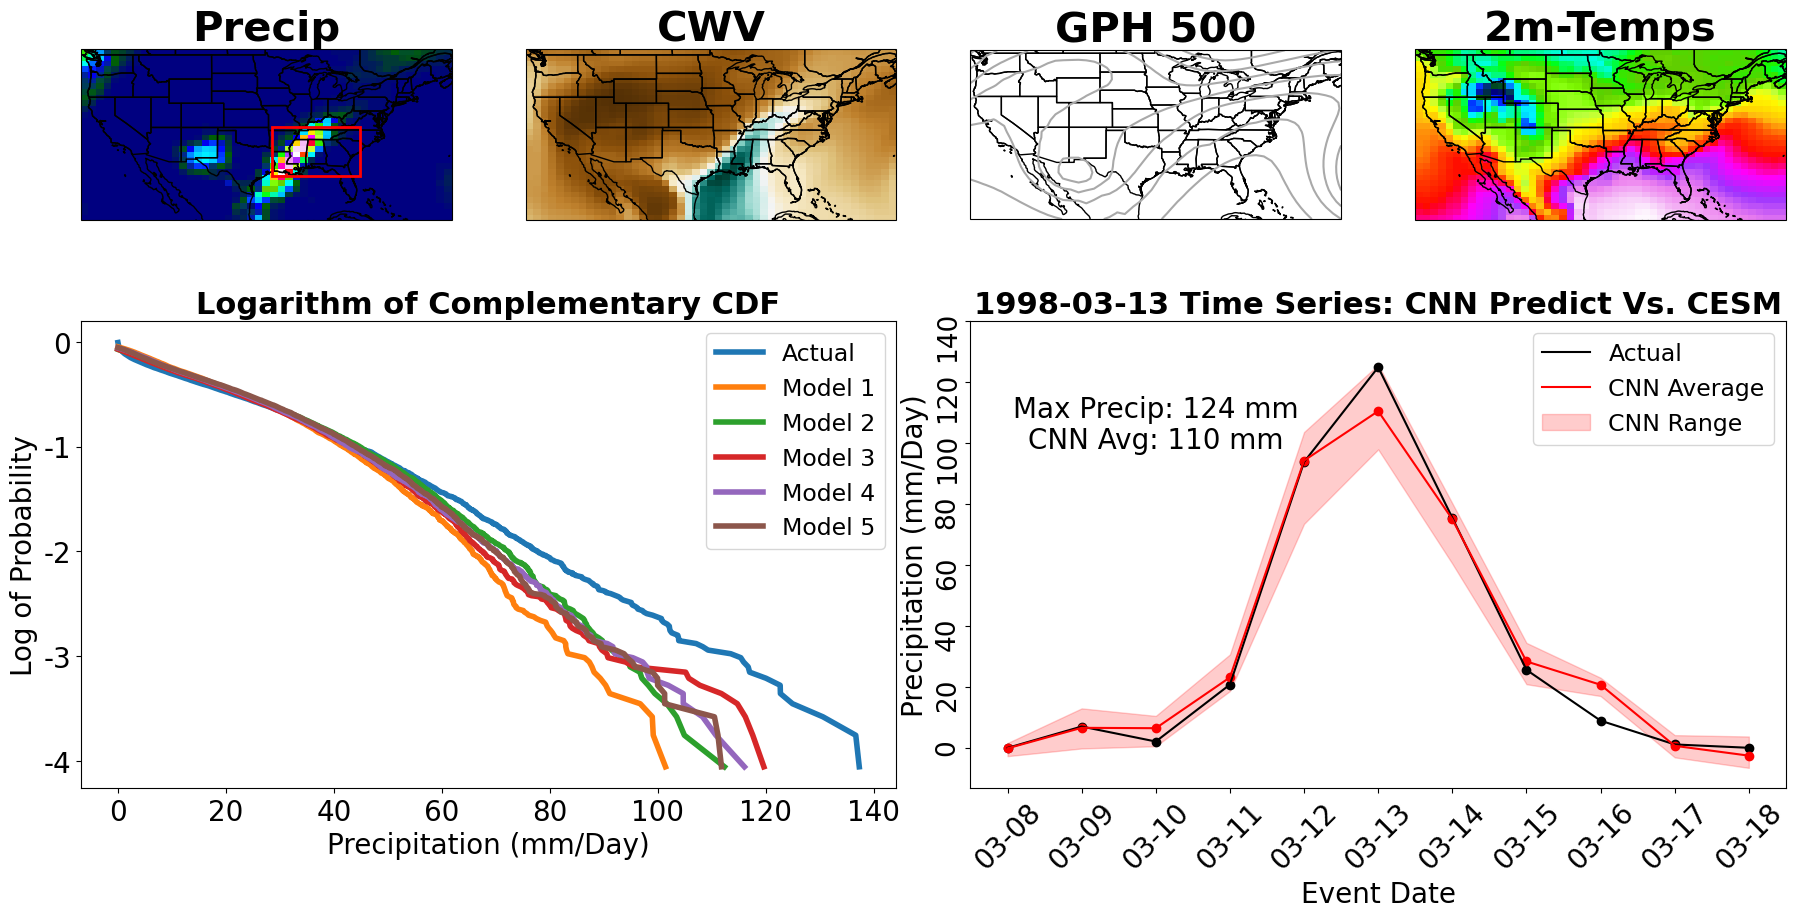

In [8]:
# Create a figure
fig = plt.figure(figsize=(22, 10))

# Define the grid layout
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 2], width_ratios=[1, 1, 1, 1])

# Top row: 4 square subplots
ax1 = fig.add_subplot(gs[0, 0], projection=projection)
ax2 = fig.add_subplot(gs[0, 1], projection=projection)
ax3 = fig.add_subplot(gs[0, 2], projection=projection)
ax4 = fig.add_subplot(gs[0, 3], projection=projection)

# Bottom row: 2 rectangular subplots spanning 2 columns each
ax5 = fig.add_subplot(gs[1, 0:2])
ax6 = fig.add_subplot(gs[1, 2:4])

# iterate through parameter data
for num, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.set_title(names[num], fontsize=30).set_weight('bold')
    locals()[f'data_{Parameter_list[num]}'] = np.array(data)[5,num,0,:,:]
    
    if num == 0:
        rect = patches.Rectangle((86, 29), 14.5, 8, linewidth=2, edgecolor='red', facecolor='none',zorder=20)
        ax.add_patch(rect)
    
    if num == 2:
        ax.contour(lon, lat, locals()[f'data_{Parameter_list[num]}'], transform=transform, colors='darkgrey', lw=10)
    else:
        ax.pcolormesh(lon, lat, locals()[f'data_{Parameter_list[num]}'], transform=transform, cmap=cmaps[num])
        
    ax.add_feature(cartopy.feature.LAND, facecolor='none', edgecolor='k', zorder=1)
    ax.add_feature(cartopy.feature.STATES, edgecolor='k')
    
#cdf/pdf plot

for num, dataset in enumerate(['Y_max_test', 'y_pred1', 'y_pred2', 'y_pred3', 'y_pred4', 'y_pred5']):
    
    locals()[f'ecdf{num}'] = stats.ecdf(df_preds[dataset].values)
    ax5.plot(locals()[f'ecdf{num}'].cdf.quantiles, np.log10(1-locals()[f'ecdf{num}'].cdf.probabilities), lw=4)
    
ax5.set_title('Logarithm of Complementary CDF', fontsize=22).set_weight('bold')
ax5.legend(['Actual', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], fontsize=17)
ax5.set_xlabel('Precipitation (mm/Day)', fontsize=20)
ax5.set_ylabel('Log of Probability', fontsize=20)
ax5.set_xticks(np.arange(0, 150, 20), np.arange(0, 150, 20), fontsize=20)
ax5.set_yticks(np.arange(0, -5, -1), np.arange(0, -5, -1), fontsize=20)
    
#time series plot    
ax6.plot(df_event['day_month'].values, df_event['precip_val'].values, color='k')

ax6.plot(df_event['day_month'].values, df_event['avg_pred'].values, color='red')
ax6.fill_between(df_event['day_month'].values, y1 = df_event['min_pred'].values,
                 y2 = df_event['max_pred'].values, color = 'red', alpha=0.2)

ax6.legend(['Actual', 'CNN Average', 'CNN Range'], fontsize=17)

plt.scatter(df_event['day_month'].values, df_event['precip_val'].values, color='k')
plt.scatter(df_event['day_month'].values, df_event['avg_pred'].values, color='red')

plt.title(f'{str(df_event["dates"][5])[:10]} Time Series: CNN Predict Vs. CESM', fontsize=22).set_weight('bold')
plt.xlabel('Event Date', fontsize=20)
plt.ylabel('Precipitation (mm/Day)', fontsize=20)
ax6.set_yticks(np.arange(0, 150, 20), np.arange(0, 150, 20), fontsize=19, rotation=90)
plt.xticks(fontsize=20, rotation=45)


plt.annotate(f'Max Precip: {int(df_event["precip_val"][5])} mm', (df_event["day_month"][2], 104), textcoords="offset points",
                 xytext=(0,10), ha='center', color='k', fontsize=20)

plt.annotate(f'CNN Avg: {int(df_event["avg_pred"][5])} mm', (df_event["day_month"][2], 94), textcoords="offset points",
                 xytext=(0,10), ha='center', color='k', fontsize=20)

plt.savefig('precip1_plots.png', format='png', dpi=500, bbox_inches='tight') 

/home/zkq5md/.local/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'lw'
  result = super().contour(*args, **kwargs)


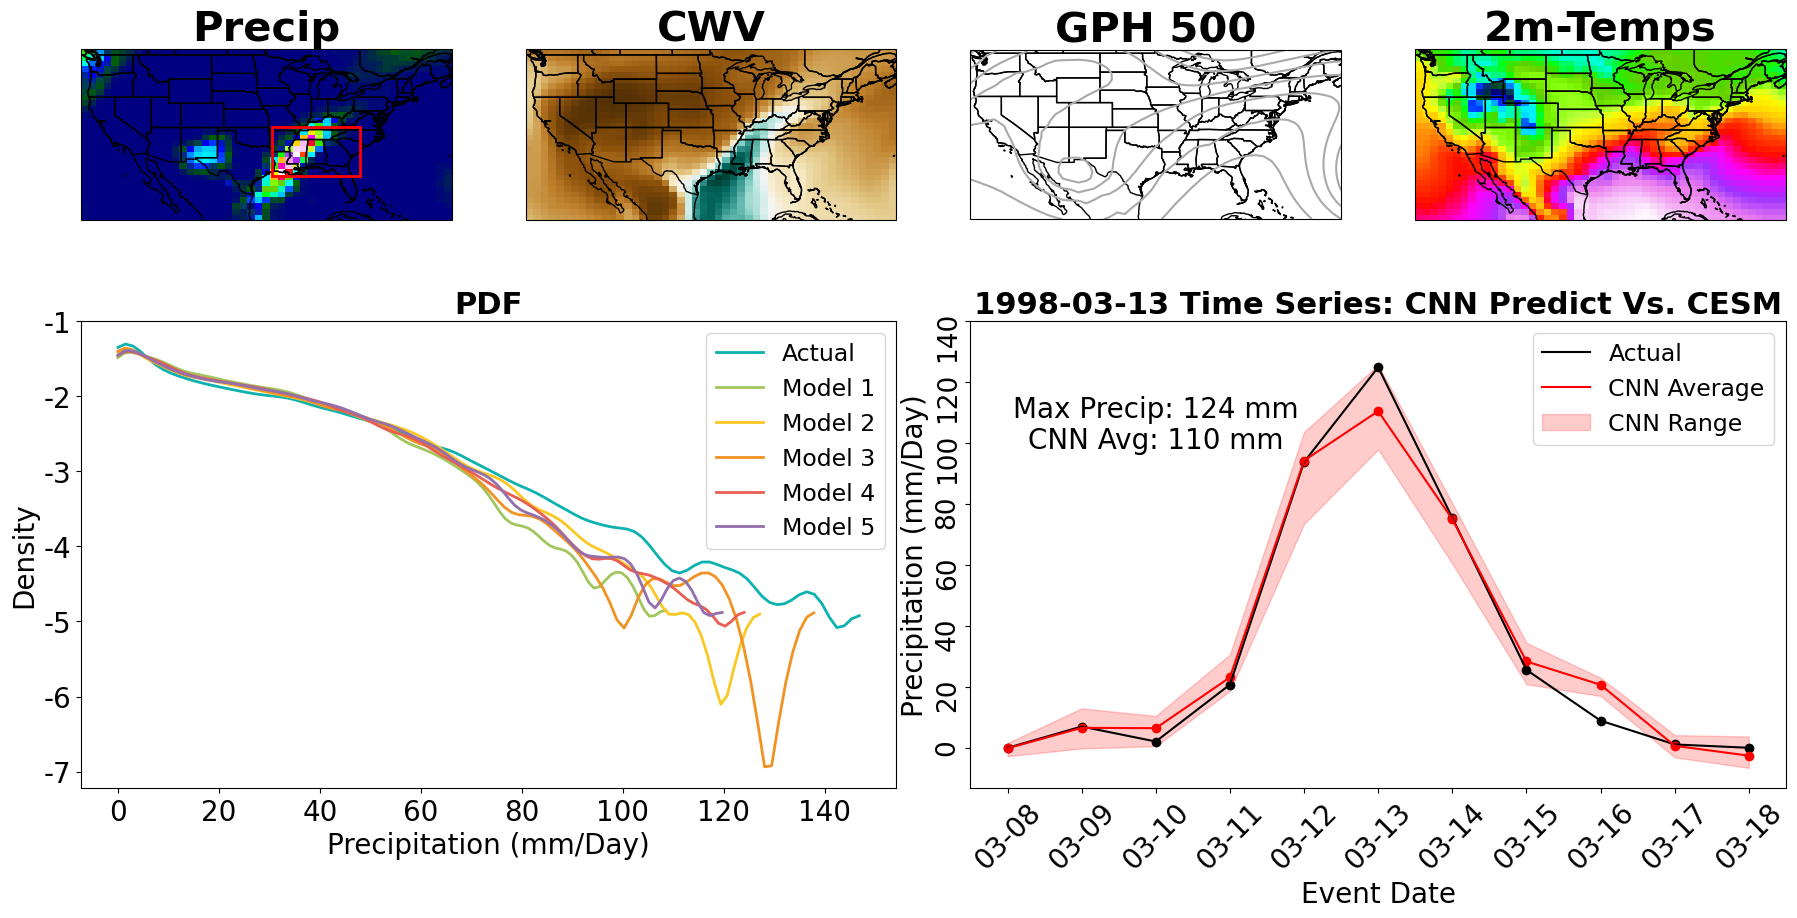

In [9]:
# Create a figure
fig = plt.figure(figsize=(22, 10))

# Define the grid layout
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 2], width_ratios=[1, 1, 1, 1])

# Top row: 4 square subplots
ax1 = fig.add_subplot(gs[0, 0], projection=projection)
ax2 = fig.add_subplot(gs[0, 1], projection=projection)
ax3 = fig.add_subplot(gs[0, 2], projection=projection)
ax4 = fig.add_subplot(gs[0, 3], projection=projection)

# Bottom row: 2 rectangular subplots spanning 2 columns each
ax5 = fig.add_subplot(gs[1, 0:2])
ax6 = fig.add_subplot(gs[1, 2:4])

# iterate through parameter data
for num, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.set_title(names[num], fontsize=30).set_weight('bold')
    locals()[f'data_{Parameter_list[num]}'] = np.array(data)[5,num,0,:,:]
    
    if num == 0:
        rect = patches.Rectangle((86, 29), 14.5, 8, linewidth=2, edgecolor='red', facecolor='none',zorder=20)
        ax.add_patch(rect)
    
    if num == 2:
        ax.contour(lon, lat, locals()[f'data_{Parameter_list[num]}'], transform=transform, colors='darkgrey', lw=10)
    else:
        ax.pcolormesh(lon, lat, locals()[f'data_{Parameter_list[num]}'], transform=transform, cmap=cmaps[num])
        
    ax.add_feature(cartopy.feature.LAND, facecolor='none', edgecolor='k', zorder=1)
    ax.add_feature(cartopy.feature.STATES, edgecolor='k')
    
#cdf/pdf plot
for num, dataset in enumerate(['Y_max_test', 'y_pred1', 'y_pred2', 'y_pred3', 'y_pred4', 'y_pred5']):
    
    #locals()[f'ecdf{num}'] = stats.norm(
    datas = df_preds[dataset].values
    
    # Create a KDE object
    kde = gaussian_kde(datas)

    # Generate x values for plotting
    x = np.linspace(np.min(datas), np.max(datas), 100)

    # Evaluate the PDF at the x values
    pdf = kde.evaluate(x)
    
    #ax5.hist(datas, density=True, bins=140, alpha=0.5)
    #x=np.linspace(np.min(datas),np.max(datas), len(datas))
    #ax5.plot(x, np.log10(pdf),lw=2)
    ax5.plot(x, np.log10(pdf),lw=2, color=colors[num])
    #ax5.plot(x, stats.norm.pdf(x),lw=2)
    
ax5.set_title('PDF', fontsize=22).set_weight('bold')
ax5.legend(['Actual', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], fontsize=17)
ax5.set_xlabel('Precipitation (mm/Day)', fontsize=20)
ax5.set_ylabel('Density', fontsize=20)
ax5.set_xticks(np.arange(0, 150, 20), np.arange(0, 150, 20), fontsize=20)
ax5.set_yticks(np.arange(-1, -8, -1), np.arange(-1, -8, -1), fontsize=20)
    
#time series plot    
ax6.plot(df_event['day_month'].values, df_event['precip_val'].values, color='k')

ax6.plot(df_event['day_month'].values, df_event['avg_pred'].values, color='red')
ax6.fill_between(df_event['day_month'].values, y1 = df_event['min_pred'].values,
                 y2 = df_event['max_pred'].values, color = 'red', alpha=0.2)

ax6.legend(['Actual', 'CNN Average', 'CNN Range'], fontsize=17)

plt.scatter(df_event['day_month'].values, df_event['precip_val'].values, color='k')
plt.scatter(df_event['day_month'].values, df_event['avg_pred'].values, color='red')

plt.title(f'{str(df_event["dates"][5])[:10]} Time Series: CNN Predict Vs. CESM', fontsize=22).set_weight('bold')
plt.xlabel('Event Date', fontsize=20)
plt.ylabel('Precipitation (mm/Day)', fontsize=20)
ax6.set_yticks(np.arange(0, 150, 20), np.arange(0, 150, 20), fontsize=19, rotation=90)
plt.xticks(fontsize=20, rotation=45)


plt.annotate(f'Max Precip: {int(df_event["precip_val"][5])} mm', (df_event["day_month"][2], 104), textcoords="offset points",
                 xytext=(0,10), ha='center', color='k', fontsize=20)

plt.annotate(f'CNN Avg: {int(df_event["avg_pred"][5])} mm', (df_event["day_month"][2], 94), textcoords="offset points",
                 xytext=(0,10), ha='center', color='k', fontsize=20)

plt.savefig('precip2_plots.png', format='png', dpi=500, bbox_inches='tight') 